##imports!!!

In [17]:

# code and ideas in this document are adopted from https://neurodsp-tools.github.io/neurodsp/
# Thank you to all those who came before me, for your contributions.
# -Kenton Guarian

# general imports
from ref_functions import *
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import preprocessing
from neurodsp.utils import create_times
from neurodsp.utils import create_freqs

# imports for simulating periodic component
from neurodsp.sim import sim_bursty_oscillation
from neurodsp.sim import sim_variable_oscillation


# for simulating aperiodic component.
from neurodsp.sim import sim_powerlaw

# for plotting
from neurodsp.plts import plot_time_series
from neurodsp.plts import plot_power_spectra
from neurodsp.spectral import compute_spectrum
import matplotlib.pyplot as plt

# for bycycle analysis
import numpy as np
import sys
# from scipy.interpolate import make_interp_spline
from scipy.signal import resample
sys.path.insert(0, '/Users/kenton/HOME/coding/python/bycycle_env/bycycle')

import mycycle

%matplotlib inline


Constants

In [18]:

n_seconds = 10
fs = 500
sliding_window_width=3
times = create_times(n_seconds=n_seconds, fs=fs)
freqs = create_freqs(freq_start=0, freq_stop=60)


thresholds = {
    'amp_fraction': 0.5,
    'amp_consistency': 0.2,
    'period_consistency': 0.2,
    'monotonicity': 0.2,
    'min_n_cycles': 1
}

simulating signals.

In [19]:
# bursts and signals taken from tutorial pages.
burst0 = sim_bursty_oscillation(n_seconds=n_seconds, fs=fs, freq=10, burst_def='durations', burst_params={
    'n_cycles_burst': 3, 'n_cycles_off': 3})
burst1 = sig = sim_bursty_oscillation(n_seconds=n_seconds, fs=fs, freq=10, burst_params={
    'enter_burst': 0.2, 'leave_burst': 0.8})
burst2 = sim_bursty_oscillation(n_seconds=n_seconds, fs=fs, freq=10, burst_def='durations',
                                burst_params={'n_cycles_burst': 3, 'n_cycles_off': 5})
burst3 = sim_bursty_oscillation(n_seconds=n_seconds, fs=fs, freq=10, burst_def='durations', burst_params={
    'n_cycles_burst': 8, 'n_cycles_off': 20})
burst4 = sig = sim_bursty_oscillation(n_seconds=n_seconds, fs=fs, freq=10, burst_params={
    'enter_burst': 0.2, 'leave_burst': 0.8})
burst5 = sim_bursty_oscillation(n_seconds=n_seconds, fs=fs, freq=10, burst_def='durations',
                                burst_params={'n_cycles_burst': 3, 'n_cycles_off': 3})

sig0 = sim_powerlaw(n_seconds=n_seconds, fs=fs, exponent=-2.0)

sig1 = sim_powerlaw(n_seconds=n_seconds, fs=fs,
                    exponent=-1.5, f_range=(2, None))
sig2 = sim_powerlaw(n_seconds=n_seconds, fs=fs, exponent=-0.5)

sig3 = sim_powerlaw(n_seconds=n_seconds, fs=fs,
                    exponent=-3, f_range=(2, None))


bursts = [burst3, burst5]
sigs = [sig0, sig1, sig2, sig3]
ratios = [10, 1, 0.5, 0.1, 0.0]

combined_sigs = [None]*(len(bursts) * len(sigs)*len(ratios))

# for y_vals in all_to_plot:
#     plot_time_series(times=times, sigs=y_vals)
# tested, looks good.

for i in range(len(bursts)):
    for j in range(len(sigs)):
        for k in range(len(ratios)):
            combined_sigs[len(sigs)*len(ratios)*i + len(ratios)
                          * j+k] = bursts[i]+10*ratios[len(ratios)-k-1]*sigs[j]
            

bm = mycycle.Bycycle()

/Users/kenton/HOME/coding/python/bycycle_env/bycycle/mycycle/objs/fit.py:36: UserWarning: 
                No burst detection thresholds are provided. This is not recommended. Please
                inspect your data and choose appropriate parameters for 'thresholds'.
                Default burst detection parameters are likely not well suited for your
                desired application.
                
  warnings.warn("""


Separate simulated signals based on known burst/aperiodic differences.

In [20]:
# TODO: do this.

K-Means on hyperparameters

In [21]:
# for sig in combined_sigs:
#     keys, hyperparams = extract_cleaned_hyperparameters_from_signal(bm, sig,500,3)
#     scaler = preprocessing.StandardScaler().fit(hyperparams)
#     print(keys)
#     print(hyperparams)
#     hyperparams_standardized = scaler.transform(hyperparams)
#     kmeans_model = KMeans(n_clusters=2, random_state=0, n_init="auto")
#     kmeans = kmeans_model.fit_predict(hyperparams_standardized.T)
#     sig_window_indices = create_window_indices_from_signal(bm, sig, 500, 3)
#     sig_windows = get_signal_windows(sig, sig_window_indices)
#     sig_windows = sig_windows[1:len(sig_windows)-1]

#     group0 = []
#     group1 = []
#     for i in range(len(kmeans)):
#         if kmeans[i]==0:
#             group0.append(sig_windows[i-1])
#         else:
#             group1.append(sig_windows[i-1])

#     print(len(group0))
#     print(len(group1))
#     plt.figure()
#     for i in range(len(group0)):
#         plt.plot(np.linspace(0,len(group0[i]),len(group0[i])), group0[i], alpha=0.5)
#     print(len(group0))
#     plt.figure()
#     for i in range(len(group1)):
#         plt.plot(np.linspace(0,len(group1[i]),len(group1[i])), group1[i], alpha=0.5)
#     print(len(group1))
#     plt.show()


Add autocorrelation hyperparameters to the features NDarray

Index(['amp_fraction', 'amp_consistency', 'period_consistency', 'monotonicity',
       'period', 'time_peak', 'time_trough', 'volt_peak', 'volt_trough',
       'time_decay', 'time_rise', 'volt_decay', 'volt_rise', 'volt_amp',
       'time_rdsym', 'time_ptsym', 'band_amp', 'sample_peak',
       'sample_last_zerox_decay', 'sample_zerox_decay', 'sample_zerox_rise',
       'sample_last_trough', 'sample_next_trough', 'is_burst'],
      dtype='object')
[[0.6931818181818182 1.0 1.0 ... 87 137 True]
 [0.6931818181818182 1.0 1.0 ... 137 187 True]
 [0.6931818181818182 1.0 1.0 ... 187 237 True]
 ...
 [0.6931818181818182 1.0 1.0 ... 4487 4537 True]
 [0.6931818181818182 0.5 0.78 ... 4537 4587 False]
 [0.26136363636363635 -1 -1 ... 4587 4626 False]]
4587
4587


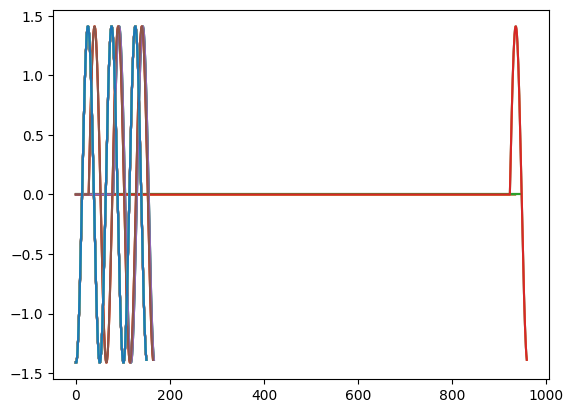

i=0
i=1
i=2
i=3
i=4
i=5
i=6
i=7
i=8
i=9
i=10
i=11
i=12
i=13
i=14
i=15
i=16
i=17
i=18
i=19
i=20
i=21
i=22
i=23
i=24
i=25
i=26
i=27
i=28
i=29
i=30
i=31
i=32
i=33
i=34
i=35
i=36
i=37
i=38
i=39
i=40
i=41
i=42
43
1032
[[-1.66533454e-16  0.00000000e+00  0.00000000e+00 ... -5.55111512e-17
  -8.32667268e-17  8.32667268e-17]
 [-1.66533454e-16  0.00000000e+00  0.00000000e+00 ... -5.55111512e-17
  -8.32667268e-17  8.32667268e-17]
 [-1.66533454e-16  0.00000000e+00  0.00000000e+00 ... -5.55111512e-17
  -8.32667268e-17  8.32667268e-17]
 ...
 [-1.66533454e-16  0.00000000e+00  0.00000000e+00 ... -5.55111512e-17
  -8.32667268e-17  8.32667268e-17]
 [-1.66533454e-16  0.00000000e+00  0.00000000e+00 ... -5.55111512e-17
  -8.32667268e-17  8.32667268e-17]
 [-1.66533454e-16  0.00000000e+00  0.00000000e+00 ... -5.55111512e-17
  -8.32667268e-17  8.32667268e-17]]
[array([ 2.61363636e-01, -1.00000000e+00, -1.00000000e+00,  4.61538462e-01,
        3.90000000e+01,  1.80000000e+01,  2.00000000e+01,  0.00000000e+00,


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


IndexError: list index out of range

In [23]:
for sig in combined_sigs:
    # extract hypeparams
    keys, hyperparams = extract_cleaned_hyperparameters_from_signal(bm, sig,500,3)
    print(keys)
    print(hyperparams)
    sig_window_indices = create_window_indices_from_signal(bm, sig, 500, 3)
    sig_windows = get_signal_windows(sig, sig_window_indices)
    # sig_windows = sig_windows[1:len(sig_windows)-1]
    corr = autocorrelate_all_windowed_signals(sig_windows)
    longest_corr = 0
    for i in range(len(corr)):
        currcorrlen = len(corr[i])
        if currcorrlen>longest_corr:
            longest_corr = currcorrlen

    hp_size = len(hyperparams)
    hp0_size = len(hyperparams[0])
    new_hyperparams = [np.zeros(hp0_size+longest_corr)]*hp_size
    for i in range(len(hyperparams)):
        print("i=%d"%i)
        for j in range(hp0_size):
            new_hyperparams[i][j] = hyperparams[i][j]
        if i>0 and i < len(corr)-1:
            for j in range(len(corr[i-1])):
                array_idx = hp0_size+j
                new_hyperparams[i][array_idx]=corr[i-1][j]
        

    print(len(new_hyperparams))
    print(hyperparams.size)
    # standardize for k-means. take out and do for whole including autocorr
    scaler = preprocessing.StandardScaler().fit(new_hyperparams)
    new_hyperparams_standardized = scaler.transform(new_hyperparams)
    kmeans_model = KMeans(n_clusters=2, random_state=0, n_init="auto")
    kmeans = kmeans_model.fit_predict(new_hyperparams_standardized.T)

    print(new_hyperparams_standardized)
    print(new_hyperparams)

    # 
    group0 = []
    group1 = []
    for i in range(len(kmeans)):
        if kmeans[i]==0:
            group0.append(sig_windows[i])
        else:
            group1.append(sig_windows[i])

    print(len(group0))
    print(len(group1))
    plt.figure()
    for i in range(len(group0)):
        plt.plot(np.linspace(0,len(group0[i]),len(group0[i])), group0[i], alpha=0.5)
    print(len(group0))
    plt.figure()
    for i in range(len(group1)):
        plt.plot(np.linspace(0,len(group1[i]),len(group1[i])), group1[i], alpha=0.5)
    print(len(group1))
    plt.show()


Sliding Window Algorithm K-Means into two categories

In [ ]:

for sig_index in range(len(combined_sigs)):
    bm = mycycle.Bycycle(thresholds=thresholds)
    # single recording
    sig = combined_sigs[sig_index]

    # freqs, powers = compute_spectrum(sig=sig, fs=fs)
    # bm.report()
    # plt.show()


    sig_window_indices = create_window_indices_from_signal(bm, sig, 500, 3)
    sig_windows = get_signal_windows(sig, sig_window_indices)
    sig_windows_homogeneous_shape = [None]*len(sig_windows)

    longest_signal = 0
    for sig in sig_windows:
        length = len(sig)
        if length > longest_signal:
            longest_signal = length

    new_x = np.linspace(0,longest_signal,longest_signal)
    for i in range(len(sig_windows)):
        # spline = make_interp_spline(np.linspace(0,len(sig_windows[i]),len(sig_windows[i])), sig_windows[i])
        # sig_windows_homogeneous_shape[i]=spline(new_x)
        resampled_sig = resample(sig_windows[i],longest_signal)
        print(len(resampled_sig))
        sig_windows_homogeneous_shape[i]=resampled_sig
        
    scaler = preprocessing.StandardScaler().fit(sig_windows_homogeneous_shape)
    norm_homog_coll = scaler.transform(sig_windows_homogeneous_shape)
    # print(sig_windows.)
    # print(type(sig_windows))

    group0 = []
    group1 = []
    kmeans_model = KMeans(n_clusters=2, random_state=0, n_init="auto")
    kmeans = kmeans_model.fit_predict(norm_homog_coll)
    for i in range(len(kmeans)):
        if kmeans[i]==0:
            group0.append(sig_windows_homogeneous_shape[i])
        else:
            group1.append(sig_windows_homogeneous_shape[i])

    plt.figure()
    for i in range(len(group0)):
        plt.plot(np.linspace(0,len(group0[i]),len(group0[i])), group0[i], alpha=0.5)
    print(len(group0))
    plt.figure()
    for i in range(len(group1)):
        plt.plot(np.linspace(0,len(group1[i]),len(group1[i])), group1[i], alpha=0.5)
    print(len(group1))
    plt.show()

print("done")


